In [61]:
# install packages by pip3 install package_name
import itertools
import json
import pickle
import string
import numpy as np


from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [62]:
# Generate Location-Based Dataset
dt_dir = "ECE219_tweet_data/"
file_name = ["tweets_#superbowl.txt"]

ma_flags = ["Massachusetts","Boston","MA"]
wa_flags = ["Washington","Seattle","WA"]

tweet_dt = []

with open(dt_dir+file_name[0]) as f:
    for tweets in f:
        json_tweet = json.loads(tweets)
        location = json_tweet['tweet']['user']['location']
        location_flag = False
        for m in ma_flags:
            if m in location:
                location_flag = True
                tweet_dt.append((json_tweet['tweet']['text'],"MA"))
                break
        if not location_flag:
            for w in wa_flags:
                if w in location:
                    location_flag = True
                    tweet_dt.append((json_tweet['tweet']['text'],"WA"))
                                        
with open('locationBasedDataset.pickle', 'wb') as handle:
    pickle.dump(tweet_dt, handle)

In [6]:
# Load data if already generated
with open('locationBasedDataset.pickle','rb') as handle:
    tweet_dt = pickle.load(handle)
    
data = np.array(tweet_dt)

In [63]:
# Pre-process Tweets
clean_data = set()
#table = str.maketrans({key: None for key in string.punctuation})
english_stopwords = stopwords.words('english')
for n,stopword in enumerate(english_stopwords):
    english_stopwords[n] = stopword.translate(str.maketrans({key: None for key in string.punctuation})).lower()
english_stopwords = set(english_stopwords)

def clean_tweet(tweet):
    # Split by white space
    words = tweet.split()
    # Remove anything with "@", "t.co","&"
    for n,word in enumerate(words):
        if "@" in word or "t.co" in word:# or "&" in word:
            words[n] = ""
        else:
            # Remove punctuation and lowercase
            words[n] = word.translate(table).lower()
            # Check if clean word in clean stopword set
            if words[n] in english_stopwords or not words[n].isalnum():
                words[n] = ""
            
    clean_tweet = " ".join(filter(None,words))
    return clean_tweet
for i in range(len(data)):
    tweet = data[i,0]
    clean_data.add((clean_tweet(tweet),data[i,1]))
clean_data = list(clean_data)
clean_data = np.array(clean_data)
np.random.shuffle(clean_data)

In [64]:
SPLIT_TRAIN_RATIO = 0.8 
splitIndex = int(clean_data.shape[0]*SPLIT_TRAIN_RATIO)

vectorizer = TfidfVectorizer(min_df=15)
vectorized_tweets_train = vectorizer.fit_transform(clean_data[:splitIndex,0]) # clean_data is now an array
vectorized_tweets_test = vectorizer.transform(clean_data[splitIndex:,0])
binarized_labels = clean_data[:,1].copy()
for n,label in enumerate(binarized_labels):
    if label == "MA":
        binarized_labels[n] = 0
    else:
        binarized_labels[n] = 1
        
y_train = binarized_labels[:splitIndex].astype('int')
y_test = binarized_labels[splitIndex:].astype('int')
x_train = vectorized_tweets_train
x_test = vectorized_tweets_test

In [46]:
def calculate_metrics(true_value,predicted_value):
    print('Accuracy: ' + str(metrics.accuracy_score(true_value, predicted_value)))
    print('Precision: ' + str(metrics.precision_score(true_value, predicted_value)))
    print('Recall: ' + str(metrics.recall_score(true_value, predicted_value)))

In [53]:
def plot_cm(cm):
    classes = ['Massachussetts', 'Washington']
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > (cm.max() / 2.) else "black")

    plt.tight_layout()
    plt.ylabel('True Value')
    plt.xlabel('Predicted Value')
    plt.show()

In [54]:
def plot_roc(model, data, labels, clfType):
    if clfType == "LogisticRegression":
        scores = model.decision_function(data)
    else:
        scores = model.predict_log_proba(data)[:,1]
        
    fpr, tpr, thresholds = roc_curve(labels,scores)
    plt.plot(fpr,tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.7217115342525717
Precision: 0.7170097873776577
Recall: 0.83069403714565


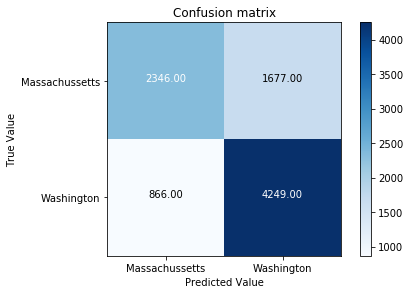

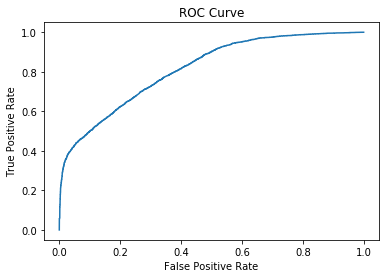

In [55]:
LogisticRegressionClassifier = LogisticRegression()
LogisticRegressionClassifier.fit(x_train,y_train)
train_predictions = LogisticRegressionClassifier.predict(x_train)
test_predictions = LogisticRegressionClassifier.predict(x_test)

calculate_metrics(y_test,test_predictions)
plot_cm(confusion_matrix(y_test,test_predictions))
plot_roc(LogisticRegressionClassifier,x_test,y_test,clfType="LogisticRegression")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.714926679798643
Precision: 0.6778628117913832
Recall: 0.9350928641251222


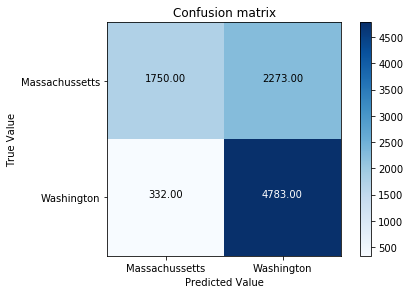

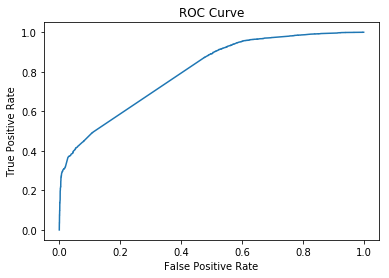

In [56]:
rfc = RandomForestClassifier(max_depth=30)
rfc.fit(x_train,y_train)
train_predictions = rfc.predict(x_train)
test_predictions = rfc.predict(x_test)

calculate_metrics(y_test,test_predictions)
plot_cm(confusion_matrix(y_test,test_predictions))
plot_roc(rfc,x_test,y_test,clfType="RandomForest")

Accuracy: 0.617093455898446
Precision: 0.7416267942583732
Recall: 0.48484848484848486


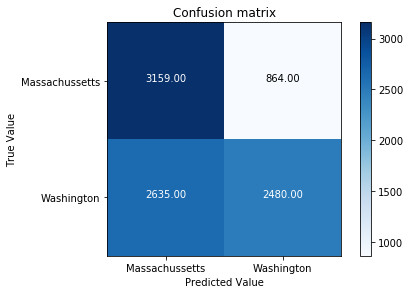

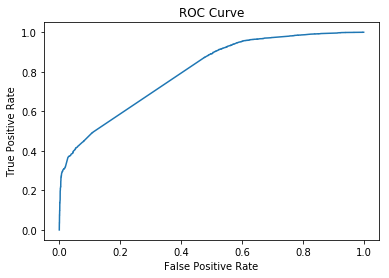

In [57]:
nb = GaussianNB()
nb.fit(x_train.toarray(),y_train)
train_predictions = nb.predict(x_train.toarray())
test_predictions = nb.predict(x_test.toarray())

calculate_metrics(y_test,test_predictions)
plot_cm(confusion_matrix(y_test,test_predictions))
roc_plotter(rfc,x_test,y_test,clfType="NaiveBayes")